In [1]:
import pandas as pd
import bs4
import datetime
from datetime import date
from datetime import datetime

import re
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.preprocessing import StandardScaler
from math import sqrt
from textblob import TextBlob

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import pygeohash as gh
#from gensim.test.utils import datapath

/Users/danielsvoboda/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/danielsvoboda/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## Class that performs preprocessing of the Meetup dataset in order to get a lemmatized dataset from the text in the group name and description
## in order to get a lemmatized dataset for Gensim's LDA.
class MeetupModel:
    def __init__(self, fileName):
        self.df = pd.read_csv(fileName, sep='\t', encoding='utf-8')
        self.df_actual = pd.DataFrame()
        
    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(self, texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in self.stop_words] for doc in texts]

    def make_bigrams(self, texts):
        return [self.bigram_mod[doc] for doc in texts]

    def make_trigrams(self, texts):
        return [self.trigram_mod[self.bigram_mod[doc]] for doc in texts]

    ## Perform lemmatization of corpus with unigrams, bigrams and trigrams.  Keep only the nouns, adjectives, verbs, and adverbs.
    def lemmatization(self, texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = self.nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    ## Preprocess the dataset by converting dates into individual columns for month, day and year.  Convert also latitude and longitude to
    ## geohasing and parse out xml tags on description.
    def preProcessingDataFrame(self):
        self.df['group_created'] = self.df['group_created'].apply(lambda s: s / int(1000))
        self.df['month'] = self.df['group_created'].apply(lambda s: datetime.utcfromtimestamp(s).strftime('%m'))
        self.df['day'] = self.df['group_created'].apply(lambda s: datetime.utcfromtimestamp(s).strftime('%d'))
        self.df['year'] = self.df['group_created'].apply(lambda s: datetime.utcfromtimestamp(s).strftime('%Y'))
        self.df['hour'] = self.df['group_created'].apply(lambda s: datetime.utcfromtimestamp(s).strftime('%H'))
        self.df['day_of_week'] = self.df['group_created'].apply(lambda s: datetime.utcfromtimestamp(s).weekday())
        self.df['weekend'] = self.df['day_of_week'].apply(lambda s: 1 if s >= 5 else 0)
        self.df['local_date'] = self.df['local_date'].fillna("2018-10-13")
        self.df_temp = self.df['local_date'].str.split('-', expand=True)
        self.df['month_meetup'] = self.df_temp[1]
        self.df['day_meetup'] = self.df_temp[2]
        self.df['local_time'] = self.df['local_time'].fillna("19:00")
        self.df_temp = self.df['local_time'].str.split(':', expand=True)
        self.df['hour_meetup'] = self.df_temp[1]
        self.df['day_of_week_meetup'] = self.df.apply(lambda x: datetime(2018, int(x.month_meetup), int(x.day_meetup)).weekday(), axis=1)
        self.df['weekend_meetup'] = self.df['day_of_week_meetup'].apply(lambda s: 1 if s >= 5 else 0)
        self.df['geohash']=self.df.apply(lambda x: gh.encode(x.group_lat, x.group_lat, precision=4), axis=1)
        self.df_temp = self.df['group_localized_location'].str.split(',', expand=True)
        self.df['region'] = self.df_temp[1]
        self.df['description'] = self.df['description'].fillna(" ")
        self.df['description'] = self.df['description'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
        self.df['description_and_name'] = self.df['description'] + self.df['name']
    
    ## For our actual dataset, we will be using only a subset of the dataset for now.  These indicate columns where none of them have a NA value
    ## Here, we do one hot encoding of categorical variables while joining other variables that are continuous.  We use month_meetup, day_meetup,
    ## and hour_meetup to organize later the dataset by date.
    def createActualDataFrame(self):
        self.df_actual = pd.get_dummies(self.df['month_meetup'], prefix = 'month_meetup')
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['day_meetup'], prefix = 'day_meetup'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['hour_meetup'], prefix = 'hour_meetup'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['day_of_week_meetup'], prefix = 'day_of_week_meetup'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['weekend_meetup'], prefix = 'weekend_meetup'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['geohash'], prefix = 'geohash'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['region'], prefix = 'region'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['group_country'], prefix = 'group_country'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['group_join_mode'], prefix = 'group_join_mode'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['group_timezone'], prefix = 'group_timezone'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['group_who'], prefix = 'group_who'))
        self.df_actual = self.df_actual.join(pd.get_dummies(self.df['visibility'], prefix = 'visibility'))
        self.df_actual = self.df_actual.join(self.df['waitlist_count'])
        self.df_actual = self.df_actual.join(self.df['description_and_name'])
        self.df_actual = self.df_actual.join(self.df['month_meetup'])
        self.df_actual = self.df_actual.join(self.df['day_meetup'])
        self.df_actual = self.df_actual.join(self.df['hour_meetup'])
        self.df_actual = self.df_actual.join(self.df['yes_rsvp_count'])
    
    ##  In our dataset, we use the Textblob library to get the sentiment polarity and subjectivity.  Textblob assigns a score of -1 to 1 for
    ##  sentiment polarity, which we put in the sentiment column.  Subjectivity measures how objective the statement is from 0-1 with 0 being
    ##  completely objective and 1 being subjective.
    def getSentimentOfDescriptions(self):
        self.df_actual['sentiment'] = self.df_actual['description_and_name'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
        self.df_actual['subjectivity'] = self.df_actual['description_and_name'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)
        
    ## When imputing variables with NaN, we check if the column being imputed is categorical or numerical.  Categorical columns will be one-hot
    ## encoded into the dataset used for training and testing.
    def joinToActualDataFrame(self, input_df, variable):
        if (is_string_dtype(input_df[variable]) == True):
            self.df_actual = self.df_actual.join(pd.get_dummies(self.df[variable], prefix = variable))
        else:
            self.df_actual = self.df_actual.join(input_df[variable])
            
        self.df_actual[variable + '_is_NA'] = input_df[variable + '_is_NA']
    
    ##  Once we have our dataaset processed, we create training and testing sets.  We use train_test_split which splits the dataset randomly.
    ##  80% of the dataset will be used for training and 20% will be used for testing.
    def createTrainTestSets(self):
        self.train, self.test = train_test_split(self.df_actual, test_size=0.2, random_state=31)
        self.train = self.train.sort_values(["month_meetup", "day_meetup", "hour_meetup"], ascending=[True, True, True])
        self.test = self.test.sort_values(["month_meetup", "day_meetup", "hour_meetup"], ascending=[True, True, True])
     
    ## Returns the unprocessed dataset.
    def getOriginalDataset(self):
        return self.df
        
    ## Returns the training set.
    def getActualDataFrame_Train(self):
        return self.train
    
    ## Returns the testing set.
    def getActualDataFrame_Test(self):
        return self.test
    
    ## Converts sentences to work tokens via gensim's preprocess function.
    def sent_to_words(self, sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
    ## Preprocesses either the training set or test testing set.  We keep words that are greater than length 4, remove unnecessary characters,
    ## etc.
    def preprocessText(self, inputText):
        if (inputText == "train"):
            givenData = self.train
        else:
            givenData = self.test
        
        #print(self.train)
        self.stop_words = stopwords.words('english')
        self.stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'https', 'http', 'www'])
            
        # Convert to list
        givenData['description_and_name'] = givenData['description_and_name'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>4]))
        self.data = givenData.description_and_name.values.tolist()

        # Remove Links
        self.data = [re.sub(r'^https?:\/\/.*[\r\n]*.com', '', sent, flags=re.MULTILINE) for sent in self.data] 

        # Remove Emails
        self.data = [re.sub('\S*@\S*\s?', '', sent) for sent in self.data]

        # Remove new line characters
        self.data = [re.sub('\s+', ' ', sent) for sent in self.data]

        # Remove distracting single quotes
        self.data = [re.sub("\'", "", sent) for sent in self.data]

        pprint(self.data[:1])
        
        self.data_words = list(self.sent_to_words(self.data))
        self.data_words = [[word for word in sent if len(word)>4] for sent in self.data_words]

        print(self.data_words[:1])
        
    ## For either the training or testing set, we use gensim's library to get the bigrams and trigrams.
    def buildBigramTrigramModels(self):
        # Build the bigram and trigram models
        self.bigram = gensim.models.Phrases(self.data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
        self.trigram = gensim.models.Phrases(self.bigram[self.data_words], threshold=100)  

        # Faster way to get a sentence clubbed as a trigram/bigram
        self.bigram_mod = gensim.models.phrases.Phraser(self.bigram)
        self.trigram_mod = gensim.models.phrases.Phraser(self.trigram)

        # See trigram example
        print(self.trigram_mod[self.bigram_mod[self.data_words[0]]])
     
    ## Once the bigrams and trigrams are gathered, we lemmatize the corpus and keep only the nouns, adjectives, verbs, and adverbs.
    def lemmatizeData(self):
        # Remove Stop Words
        data_words_nostops = self.remove_stopwords(self.data_words)

        # Form Bigrams
        data_words_bigrams = self.make_bigrams(data_words_nostops)

        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        # python3 -m spacy download en
        self.nlp = spacy.load('en', disable=['parser', 'ner'])

        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = self.lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

        print(data_lemmatized[:1])
        return data_lemmatized
        
    

In [3]:
## LdaModel will take our lemmatized corpus from either the training or testing set and get the topic models.  For this situation, we will
## train the topic models on the training set and evaluate on the testing set.  We also can save and load the dataset which is ideal given that
## training a topic model is very laborious.
class LdaModel:
    ## Initialize the class with the lemmatized data from the previous class.  Creates a class variable corpus that will be used for training the
    ## topic models.
    def __init__(self, data_lemmatized):
        # Create Dictionary
        self.id2word = corpora.Dictionary(data_lemmatized)

        # Create Corpus
        texts = data_lemmatized

        # Term Document Frequency
        self.corpus = [self.id2word.doc2bow(text) for text in texts]

        # View
        print(self.corpus[:1])
    
    ## Save the created topic model onto a file.
    def saveModel(self, modelFile):
        self.lda_model.save(modelFile)
     
    ## Load a given topic model file onto the class variable.
    def loadModel(self, modelFile):
        self.lda_model = gensim.models.ldamodel.LdaModel.load(modelFile)
        
    ## Return the topic model.
    def returnModel(self):
        return self.lda_model
      
    ## Return the created corpus used for training the topic model.
    def returnCorpus(self):
        return self.corpus
   
    ## Compute coherence values for goodness of fits of the topic model.  Higher coherence values mean more indicative topics.
    def compute_coherence_values(self, dictionary, corpus, texts, limit, start=2, step=3):
        """
        Compute c_v coherence for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):
            model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values

    ## Once the corpus is created, run the topic model.  We will train on 30 topics.  Usually, the topic model takes about 40 min to train with
    ## the given corpus we have.
    def createLdaModel(self):
        # Build LDA model
        self.lda_model = gensim.models.ldamodel.LdaModel(corpus=self.corpus,
                                           id2word=self.id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)
        pprint(self.lda_model.print_topics())
        #temp_file = datapath("model")
        #lda_model.save(temp_file)
        return self.lda_model
        
    ## Display coherence scores to get an idea of the goodness of fit for the model.
    def displayCoherenceScores(self):
        # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
        mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=self.corpus, num_topics=20, id2word=self.id2word)
        
        # Compute Coherence Score
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=self.id2word, coherence='c_v')
        coherence_ldamallet = coherence_model_ldamallet.get_coherence()
        print('\nCoherence Score: ', coherence_ldamallet)
    
    ## Run an iteration from 2 topics to 40 to see which number of topics have the highest coherence.
    def findOptimumCoherence(self):
        # Can take a long time to run.
        model_list, coherence_values = compute_coherence_values(dictionary=self.id2word, corpus=self.corpus, texts=data_lemmatized, start=2, limit=40, step=6)
        # Show graph
        limit=40; start=2; step=6;
        x = range(start, limit, step)
        plt.plot(x, coherence_values)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        plt.legend(("coherence_values"), loc='best')
        plt.show()
    
    ## Use pyLDAvis to visualize the trained topics, see how much they overlap, and the keywords that make up each topic.  You can infer the
    ## topic based on these keywords.
    def visualizeTopics(self): # Visualize the topics
        pyLDAvis.enable_notebook()
        vis = pyLDAvis.gensim.prepare(self.lda_model, self.corpus, self.id2word)
        return vis
    

In [4]:
## Once we have the topic models and preprocessed dataset, we can begin training our models.  We have a variety of regression algorithms 
## including support vector regression, gradient boosting regression, random forest regression, neural network regression, etc.
class createModels:
    
    ## Create the training and testing sets for the regression algorithms.  Incorporate the topic distributions onto both sets and delete 
    ## unncessary columns.  Finally, use z-score scaling on both the features and labels to make it more amenable for training.
    def __init__(self, ldaModel, corpus, corpus_test, mm):
        scaler_features = StandardScaler()
        scaler_labels = StandardScaler()
        
        all_topics = lda_model.get_document_topics(corpus)
        all_topics_csr = gensim.matutils.corpus2csc(all_topics)
        df = pd.DataFrame(all_topics_csr.toarray()).T
        df_actual = mm.getActualDataFrame_Train()
        df_actual = df_actual.reset_index(drop=True)
        
        self.train_labels = df_actual['yes_rsvp_count']
        df_actual = df_actual.drop('yes_rsvp_count', 1)
        df_actual = df_actual.drop('description_and_name', 1)
        df_actual = df_actual.drop('month_meetup', 1)
        df_actual = df_actual.drop('day_meetup', 1)
        df_actual = df_actual.drop('hour_meetup', 1)
        self.train_features = pd.concat([df, df_actual], axis=1)
        
        self.train_features = scaler_features.fit_transform(self.train_features)
        #self.train_labels = scaler_labels.fit_transform(self.train_labels.reshape(-1, 1))
        
        all_topics_test = lda_model.get_document_topics(corpus_test)
        all_topics_csr_test = gensim.matutils.corpus2csc(all_topics_test)
        df_test = pd.DataFrame(all_topics_csr_test.toarray()).T
        df_actual_test = mm.getActualDataFrame_Test()
        df_actual_test = df_actual_test.reset_index(drop=True)
                
        self.test_labels = df_actual_test['yes_rsvp_count']
        df_actual_test = df_actual_test.drop('yes_rsvp_count', 1)
        df_actual_test = df_actual_test.drop('description_and_name', 1)
        df_actual_test = df_actual_test.drop('month_meetup', 1)
        df_actual_test = df_actual_test.drop('day_meetup', 1)
        df_actual_test = df_actual_test.drop('hour_meetup', 1)
        self.test_features = pd.concat([df_test, df_actual_test], axis=1)

        self.test_features = scaler_features.transform(self.test_features)
        #self.test_labels = scaler_labels.transform(self.test_labels.reshape(-1, 1))
        
    ## Performs neural network regression on the training set and evaluates on the testing set.  It will save the model with the best possible
    ## mean squared error and will stop early if the mean squared error does not change after 20 iterations.
    def neuralNetworkRegression(self):
        from keras.models import Sequential
        from keras.layers import Dense, Dropout
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        
        checkpoint1 = ModelCheckpoint(filepath='nn_model.h5', monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')
        checkpoint2 = EarlyStopping(monitor='val_mean_squared_error', patience=20, verbose=1, mode='auto')
        callbacks_list = [checkpoint1, checkpoint2]
        
        model = Sequential()
        model.add(Dense(500, input_dim=len(self.train_features[0]), kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])
        model.summary()
        model.fit(self.train_features, self.train_labels, epochs=150, batch_size=8192, verbose=1, callbacks=callbacks_list, validation_data=(self.test_features, self.test_labels))
        model.load_weights('nn_model.h5')
        return model
    
    # Define a convolutional neural netwowrk followed by a feed-forward network.  The CNN will have a model checkpoint
    # to save the best model on the testing dataset, along with early stopping so that after 10 iterations, the model
    # will stop training if there is no improvement in the testing dataset.
    def convolutionalNeuralNetworkRegression(self):
        from keras.models import Sequential
        from keras.layers import Dense, Dropout, Flatten
        from keras.callbacks import ModelCheckpoint, EarlyStopping
        from keras.layers.convolutional import Conv1D, MaxPooling1D
        
        checkpoint1 = ModelCheckpoint(filepath='nn_model_1.h5', monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='auto')
        checkpoint2 = EarlyStopping(monitor='val_mean_squared_error', patience=10, verbose=1, mode='auto')
        callbacks_list = [checkpoint1, checkpoint2]
        
        train_features = self.train_features.reshape(self.train_features.shape[0], self.train_features.shape[1], 1)
        test_features = self.test_features.reshape(self.test_features.shape[0], self.test_features.shape[1], 1)
        
        model = Sequential()
        model.add(Conv1D(20, 4, input_shape = train_features.shape[1:3], activation = 'relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.2))
        model.add(Conv1D(20, 4, activation = 'relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.2))
        model.add(Conv1D(20, 4, activation = 'relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.2))
        model.add(Conv1D(20, 4, activation = 'relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.2))
        model.add(Conv1D(20, 4, activation = 'relu'))
        model.add(MaxPooling1D(2))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(200, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='Nadam', metrics=['mse'])
        model.summary()
        model.fit(train_features, self.train_labels, epochs=150, batch_size=1024, verbose=1, callbacks=callbacks_list, validation_data=(test_features, self.test_labels))
        model.load_weights('nn_model_1.h5')
        return model
     
    ## Performs random forest regression using 100 estimators.
    def randomForestRegression(self):
        from sklearn.ensemble import RandomForestRegressor
        rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
        rf.fit(self.train_features, self.train_labels)
        return rf
    
    ## Performs support vector regression.
    def supportVectorRegression(self):
        from sklearn.svm import SVR
        svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
        svr.fit(self.train_features, self.train_labels) 
        return svr
     
    ## Performs gradient boosting regression with estimators being an input variable on how many estimators to use for the gradient boosting
    ## regression.
    def gradientBoostingRegression(self, estimators):
        from sklearn.ensemble import GradientBoostingRegressor
        params = {'n_estimators': estimators, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
        gbr = GradientBoostingRegressor(**params)
        gbr.fit(self.train_features, self.train_labels) 
        return gbr
    
    ## Performs linear regression.  We use that as a baseline.
    def linearRegression(self):
        # Import the model we are using
        from sklearn.linear_model import LinearRegression
        lr = LinearRegression()
        # Train the model on training data
        lr.fit(self.train_features, self.train_labels)
        return lr
        
    ## For a given model, get the RMS on the training set.    
    def getRMSE_Train(self, model, isCNN):
        from sklearn.metrics import mean_squared_error
        if (isCNN == True):
            from keras.models import Sequential
            from keras.layers import Dense, Dropout, Flatten
            from keras.layers.convolutional import Conv1D, MaxPooling1D
            train_features = self.train_features.reshape(self.train_features.shape[0], self.train_features.shape[1], 1)
            model = Sequential()
            model.add(Conv1D(20, 4, input_shape = train_features.shape[1:3], activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Flatten())
            model.add(Dense(200, kernel_initializer='normal', activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='linear'))
            model.load_weights('nn_model_1.h5')
            predict_train = model.predict(train_features)
            rms = sqrt(mean_squared_error(self.train_labels, predict_train))
        else:
            predict_train = model.predict(self.train_features)
            rms = sqrt(mean_squared_error(self.train_labels, predict_train))
        print(rms)
    
    ## For a given model, get the RMS on the testing set.
    def getRMSE_Test(self, model, isCNN):
        from sklearn.metrics import mean_squared_error
        if (isCNN == True):
            from keras.models import Sequential
            from keras.layers import Dense, Dropout, Flatten
            from keras.layers.convolutional import Conv1D, MaxPooling1D
            test_features = self.test_features.reshape(self.test_features.shape[0], self.test_features.shape[1], 1)
            model = Sequential()
            model.add(Conv1D(20, 4, input_shape = test_features.shape[1:3], activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Flatten())
            model.add(Dense(200, kernel_initializer='normal', activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='linear'))
            model.load_weights('nn_model_1.h5')
            predict_test = model.predict(test_features)
            rms = sqrt(mean_squared_error(self.test_labels, predict_test))
        else:
            predict_test = model.predict(self.test_features)
            rms = sqrt(mean_squared_error(self.test_labels, predict_test))
        print(rms)
    
    ## For a given model, make a plot comparing the distribution of the training set with that predicted by the model.
    def plotActualPrediction_Train(self, model, isCNN):
        if (isCNN == True):
            from keras.models import Sequential
            from keras.layers import Dense, Dropout, Flatten
            from keras.layers.convolutional import Conv1D, MaxPooling1D
            train_features = self.train_features.reshape(self.train_features.shape[0], self.train_features.shape[1], 1)
            model = Sequential()
            model.add(Conv1D(20, 4, input_shape = train_features.shape[1:3], activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Flatten())
            model.add(Dense(200, kernel_initializer='normal', activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='linear'))
            model.load_weights('nn_model_1.h5')
            predict_train = model.predict(train_features)
            train_features_df = pd.DataFrame(self.train_features)
        else:
            predict_train = model.predict(self.train_features)
            train_features_df = pd.DataFrame(self.train_features)
        
        pyplot.plot(train_features_df.index.values, self.train_labels)
        pyplot.plot(train_features_df.index.values, predict_train)
        pyplot.show()
        
    ## For a given model, make a plot comparing the distribution of the testing set with that predicted by the model.
    def plotActualPrediction_Test(self, model, isCNN):
        if (isCNN == True):
            from keras.models import Sequential
            from keras.layers import Dense, Dropout, Flatten
            from keras.layers.convolutional import Conv1D, MaxPooling1D
            test_features = self.test_features.reshape(self.test_features.shape[0], self.test_features.shape[1], 1)
            model = Sequential()
            model.add(Conv1D(20, 4, input_shape = test_features.shape[1:3], activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Conv1D(20, 4, activation = 'relu'))
            model.add(MaxPooling1D(2))
            model.add(Dropout(0.2))
            model.add(Flatten())
            model.add(Dense(200, kernel_initializer='normal', activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(200, activation='relu'))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='linear'))
            model.load_weights('nn_model_1.h5')
            predict_test = model.predict(test_features)
            test_features_df = pd.DataFrame(self.test_features)
        else:
            predict_test = model.predict(self.test_features)
            test_features_df = pd.DataFrame(self.test_features)
        
        pyplot.plot(test_features_df.index.values, self.test_labels)
        pyplot.plot(test_features_df.index.values, predict_test)
        pyplot.show()
    
    

In [5]:
## Class that will be used to impute variables on a column that has NAN.  We can then retrain our dataset with the imputed variable and see
## if there is a noticable improvement.
class imputeVariables:
    
    ## Get the original dataset before preparation for the models.  This dataset will have columns with NAN.
    def __init__(self, mm):
        self.df = mm.getOriginalDataset()
     
    ## For a given column, get the categorical count showing all the possible values in the column.  From examining this, we can
    ## decide whether to use the median value or randomly sample from the non-NA values to impute the values that have NA in the column.
    def getCategoricalCount(self, variable):
        print(self.df.groupby(variable).count())
        
    ## Print out which columns have at least one NAN in their rows.
    def getCategoriesWithNAN(self):
        print(self.df.columns[self.df.isnull().any()])
      
    ## Print out which columns do not contain NAN at all.
    def getCategoriesWithoutNAN(self):
        print(self.df.columns[~self.df.isnull().any()])
    
    ## For a given column, fill in the NAN values in their column with the given value.  Create a second column that will have a value of 1
    ## where the given column has NAN and 0 where it doesn't have NAN.
    def imputeGivenCategoricalVariable(self, variable, value):
        temp_df = self.df
        temp_df[variable] = self.df[variable].fillna(value)
        temp_df[variable + '_is_NA'] = np.where(self.df[variable].isnull(), 1, 0)
        return(temp_df)
    
    ## For a given column, fill in the NAN values in their column with a randomly sampled value from the non-NA values.  Create a second column that will have a value of 1
    ## where the given column has NAN and 0 where it doesn't have NAN.  The random sample will be sampled based on the
    ## distribution of the non-NA values of the indicated column.
    def imputeGivenCategoricalVariable_RandomSampling(self, variable):
        temp_df = self.df
        s = temp_df[variable].value_counts(normalize=True)
        print(s)
        missing = temp_df[variable].isnull()
        temp_df.loc[missing, variable] = np.random.choice(s.index, size=len(temp_df[missing]),p=s.values)
        #random_sample = temp_df[variable].dropna().sample(temp_df [variable].isnull().sum(), random_state=0, replace=True)
        #random_sample.index = temp_df[temp_df [variable].isnull()].index
        #temp_df.loc[temp_df[variable].isnull(), variable] = random_sample
        temp_df[variable + '_is_NA'] = np.where(self.df[variable].isnull(), 1, 0)
        return(temp_df)
    
    ## For a given column, fill in the NAN values in their column with the given value.  Create a second column that will have a value of 1
    ## where the given column has NAN and 0 where it doesn't have NAN.
    def imputeGivenContinuousVariable(self, variable, value):
        temp_df = self.df
        temp_df[variable] = self.df[variable].fillna(value)
        temp_df[variable + '_is_NA'] = np.where(self.df[variable].isnull(), 1, 0)
        return(temp_df)
    
    ## For a given column, fill in the NAN values in their column with a randomly sampled value from the non-NA values.  Create a second column that will have a value of 1
    ## where the given column has NAN and 0 where it doesn't have NAN.  The random sample will be sampled based on the
    ## distribution of the non-NA values of the indicated column.
    def imputeGivenContinuousVariable_RandomSampling(self, variable):
        temp_df = self.df
        s = temp_df[variable].value_counts(normalize=True)
        print(s)
        missing = temp_df[variable].isnull()
        temp_df.loc[missing, variable] = np.random.choice(s.index, size=len(temp_df[missing]),p=s.values)
        #random_sample = temp_df[variable].dropna().sample(temp_df [variable].isnull().sum(), random_state=0, replace=True)
        #random_sample.index = temp_df[temp_df [variable].isnull()].index
        #temp_df.loc[temp_df[variable].isnull(), variable] = random_sample
        temp_df[variable + '_is_NA'] = np.where(self.df[variable].isnull(), 1, 0)
        return(temp_df)
        

In [6]:
mm = MeetupModel("meetup-events-20180925_20181231.tsv")  ## Instantiate the MeetupModel class with the dataset.
mm.preProcessingDataFrame()  ## Call the method to preprocess the dataset with the given preprocessing functions.
mm.createActualDataFrame()   ## Create the dataset that will have columns on which we will be using for our model.
mm.getSentimentOfDescriptions()  ## Incorporate the sentiment polarity and subjectivity scores into our dataset.
mm.createTrainTestSets()     ## Split the dataset into training and testing sets.
mm.preprocessText("train")   ## Preprocess the training set.
mm.buildBigramTrigramModels()  ## Build the bigrams and trigrams for the training set.
data_lemmatized_train = mm.lemmatizeData()  ## Lemmatize the training dataset.

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/Users/danielsvoboda/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [7]:
mm.preprocessText("test")  ## Begin preprocessing the testing dataset.
mm.buildBigramTrigramModels()  ## Build bigrams and trigrams from the testing dataset.
data_lemmatized_test = mm.lemmatizeData()  ## Get lemmatized dataset from the testing dataset.

['Happy monthly social event designers, their colleagues, friends. Berlin '
 'Happy']
[['happy', 'monthly', 'social', 'event', 'designers', 'their', 'colleagues', 'friends', 'berlin', 'happy']]


/Users/danielsvoboda/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['happy', 'monthly', 'social', 'event', 'designers', 'their', 'colleagues', 'friends', 'berlin', 'happy']
[['happy', 'monthly', 'social', 'event', 'designer', 'colleague', 'friend', 'berlin', 'happy']]


In [8]:
ldaClass = LdaModel(data_lemmatized_train)  ## Initiate ldaClass with the lemmatized data from the training set.
ldaClass.loadModel("model.m")  ## Load the LDA model that was pretrained with the 20 topics (shown below)
corpus = ldaClass.returnCorpus()  ## Return the preprocessed corpus used to create the LDA model for the training set.

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 8), (10, 7), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1)]]


In [9]:
ldaClass_test = LdaModel(data_lemmatized_test)  ## Initialize ldaClass_test using the lemmatized data from the testing set.
corpus_test = ldaClass_test.returnCorpus()   ## Return the preprocessed corpus used to create the LDA model for the testing set.

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [10]:
lda_model = ldaClass.returnModel()  ## Return the LDA model 

In [11]:
lda_model = ldaClass.createLdaModel()  ## Demonstrates the training of the LDA model with the training set.

[(4,
  '0.014*"instruction" + 0.006*"nicht" + 0.006*"werden" + 0.004*"meetup" + '
  '0.004*"wordpress" + 0.004*"haben" + 0.004*"einen" + 0.004*"deutsch" + '
  '0.003*"tenant" + 0.003*"important"'),
 (3,
  '0.019*"camera" + 0.015*"subway" + 0.014*"scavenger" + 0.011*"train" + '
  '0.009*"station" + 0.008*"wealth" + 0.008*"system" + 0.007*"ecstatic_dance" '
  '+ 0.007*"pickup" + 0.006*"animal"'),
 (29,
  '0.098*"meditation" + 0.020*"sahaja" + 0.020*"class" + 0.014*"everyone" + '
  '0.014*"energy" + 0.012*"welcome" + 0.009*"weekly" + 0.008*"youtube_watch" + '
  '0.008*"bring" + 0.008*"place"'),
 (21,
  '0.101*"event" + 0.046*"group" + 0.033*"register" + 0.030*"attend" + '
  '0.026*"people" + 0.023*"question" + 0.016*"several" + 0.015*"number" + '
  '0.014*"click" + 0.013*"alone"'),
 (6,
  '0.017*"breakfast" + 0.014*"river" + 0.014*"mountain" + 0.014*"facebook" + '
  '0.013*"trip" + 0.013*"activity" + 0.013*"meetup" + 0.012*"organizer" + '
  '0.012*"america" + 0.012*"single"'),
 (27,
  '0.

In [12]:
#lda_model.save("model.m")
ldaClass.saveModel("model.m")  ## Save the model onto a file called model.m.

In [13]:
#lda_model = gensim.models.ldamodel.LdaModel.load("model.m")
ldaClass.loadModel("model.m") ## Load the model from the file onto our class.

In [11]:
vis = ldaClass.visualizeTopics()  ## Visualize the topics.  Will show the most important keywords overall along with keywords for each topic.

In [12]:
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
24     9.293638        1       1  0.272142  0.060975
19     7.889123        1       2  0.065922  0.118233
11     7.522912        1       3 -0.090329  0.174092
14     6.543089        1       4 -0.052417  0.213854
25     5.776459        1       5  0.296777 -0.072669
0      4.515737        1       6  0.011840  0.124990
26     3.977695        1       7 -0.035217 -0.068029
16     3.639885        1       8 -0.071677  0.001754
18     3.634746        1       9 -0.098570  0.155355
21     3.413817        1      10  0.244668  0.002989
23     3.392407        1      11  0.238516 -0.058282
7      3.026644        1      12 -0.085557  0.155371
28     2.933708        1      13  0.218590 -0.044769
1      2.706727        1      14 -0.051209  0.058008
13     2.654252        1      15  0.003341  0.068987
10     2.632241        1      16 -0.117738  0.137508
12     2.405675        1      17 -0.172349 -0.063364
2      2.241477        1      18 -0.131170 -0.073531
17     2.218469        1      19 -0.086088 -0.049176
8      2.189888        1      20 -0.016571 -0.011812
27     2.113247        1      21  0.051775 -0.038274
29     1.969987        1      22  0.026819  0.082860
20     1.939222        1      23 -0.008747 -0.112979
6      1.890400        1      24 -0.012895 -0.054469
9      1.889109        1      25 -0.020811 -0.041361
22     1.680095        1      26  0.024487 -0.010044
15     1.669068        1      27 -0.133677 -0.086396
4      1.554834        1      28 -0.109900 -0.190129
5      1.525653        1      29 -0.041819 -0.183245
3      1.159792        1      30 -0.118137 -0.196447, topic_info=      Category          Freq                  Term         Total  loglift  \
term                                                                        
223    Default  45550.000000                 event  45550.000000  30.0000   
23     Default  29336.000000                 group  29336.000000  29.0000   
117    Default  14165.000000                 class  14165.000000  28.0000   
76     Default  23569.000000                meetup  23569.000000  27.0000   
198    Default  19805.000000                people  19805.000000  26.0000   
504    Default   6517.000000                 dance   6517.000000  25.0000   
486    Default  19082.000000                ticket  19082.000000  24.0000   
1122   Default   7874.000000              purchase   7874.000000  23.0000   
96     Default   5829.000000            meditation   5829.000000  22.0000   
298    Default   8039.000000              business   8039.000000  21.0000   
633    Default  18027.000000                member  18027.000000  20.0000   
246    Default  15730.000000                attend  15730.000000  19.0000   
213    Default  15207.000000                 drink  15207.000000  18.0000   
621    Default  12067.000000               session  12067.000000  17.0000   
377    Default  12392.000000                 learn  12392.000000  16.0000   
211    Default  11962.000000                london  11962.000000  15.0000   
2608   Default   7837.000000                 party   7837.000000  14.0000   
398    Default  10513.000000                 night  10513.000000  13.0000   
1      Default   7337.000000                  game   7337.000000  12.0000   
7      Default  13248.000000               welcome  13248.000000  11.0000   
429    Default  10849.000000                friend  10849.000000  10.0000   
11715  Default   4609.000000   dljparty_ticketleap   4609.000000   9.0000   
287    Default  16416.000000                 bring  16416.000000   8.0000   
1615   Default   5476.000000                 music   5476.000000   7.0000   
2739   Default   3065.000000                berlin   3065.000000   6.0000   
1572   Default   5320.000000                  date   5320.000000   5.0000   
4224   Default   4429.000000                prepay   4429.000000   4.0000   
425    Default   6321.000000

In [13]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

In [94]:
lr = cm.linearRegression()   ## Let's try training a linear regression algorithm.  We can use this as our baseline.

/Users/danielsvoboda/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [95]:
cm.getRMSE_Train(lr)  ## Get the RMS for the training set.  This will be our baseline.

0.7428749792238979


In [96]:
cm.getRMSE_Test(lr)  ## Get the RMS for the testing set.  This will be our baseline.

295195762752.9906


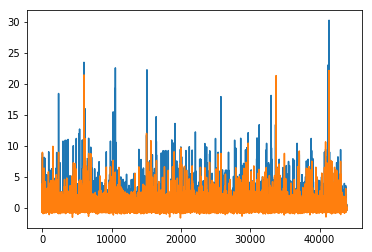

In [97]:
cm.plotActualPrediction_Train(lr)  ## Get an overlay of the training set distribution versus the predicted distribution of the training set.

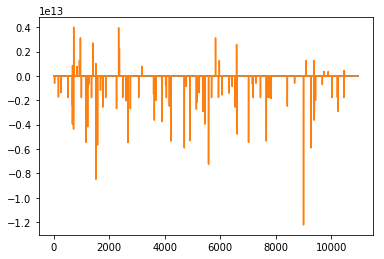

In [98]:
cm.plotActualPrediction_Test(lr)  ## Get an overlay of the testing set distribution versus the predicted distribution of the testing set.  This is our baseline.

In [14]:
gbr = cm.gradientBoostingRegression(1000)   ## Let's try training a gradient boosting regression with 1000 estimators.

In [16]:
cm.getRMSE_Train(gbr, False)  ## Get the RMS for the training set.

19.505769248913126


In [17]:
cm.getRMSE_Test(gbr, False)  ## Get the RMS for the testing set.

22.305782506208732


In [ ]:
cm.plotActualPrediction_Train(gbr, False)  ## Get an overlay of the training set distribution versus the predicted distribution of the training set.

In [ ]:
cm.plotActualPrediction_Test(gbr, False)  ## Get an overlay of the testing set distribution versus the predicted distribution of the testing set.

In [ ]:
rf = cm.randomForestRegression()

In [ ]:
cm.getRMSE_Train(rf, False)

In [ ]:
cm.getRMSE_Test(rf, False)

In [ ]:
cm.plotActualPrediction_Train(rf, False)

In [ ]:
cm.plotActualPrediction_Test(rf, False)

In [13]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               1376500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total para

In [14]:
cm.getRMSE_Train(nn)  ## Get the RMS for the training set of the neural network model.

17.039181308712074


In [15]:
cm.getRMSE_Test(nn)  ## Get the RMS for the testing set of the neural network model.

19.731072829564702


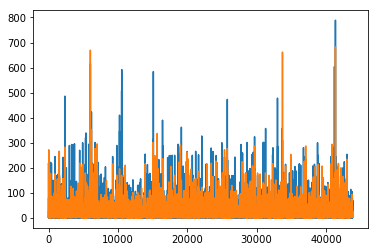

In [16]:
cm.plotActualPrediction_Train(nn)  ## Get the plot overlay for the training set.  We can see that this is the best out of all models.

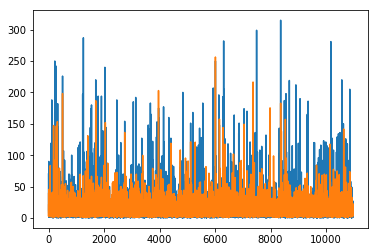

In [17]:
cm.plotActualPrediction_Test(nn)  ## Get the plot overlay for the testing set.  We can see that this is the best out of all the models.

In [22]:
cnn = cm.convolutionalNeuralNetworkRegression()   ## Let's try training with a convolutional neural network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 2749, 20)          100       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1374, 20)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1374, 20)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1371, 20)          1620      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 685, 20)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 685, 20)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 682, 20)           1620      
__________


Epoch 00018: val_mean_squared_error did not improve from 405.75156
Epoch 19/150
43880/43880 [==============================] - 79s 2ms/step - loss: 510.4207 - mean_squared_error: 510.4207 - val_loss: 399.4957 - val_mean_squared_error: 399.4957

Epoch 00019: val_mean_squared_error improved from 405.75156 to 399.49568, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 79s 2ms/step - loss: 502.4040 - mean_squared_error: 502.4040 - val_loss: 403.8374 - val_mean_squared_error: 403.8374

Epoch 00020: val_mean_squared_error did not improve from 399.49568
Epoch 21/150
43880/43880 [==============================] - 79s 2ms/step - loss: 490.7619 - mean_squared_error: 490.7619 - val_loss: 402.2263 - val_mean_squared_error: 402.2263

Epoch 00021: val_mean_squared_error did not improve from 399.49568
Epoch 22/150
43880/43880 [==============================] - 79s 2ms/step - loss: 497.4503 - mean_squared_error: 497.4503 - val_loss: 409.1339 - val_mean_squared

In [35]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

20.221684243656703


In [39]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.542933473542362


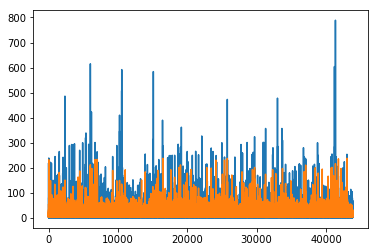

In [48]:
cm.plotActualPrediction_Train(cnn, True)  ## Get an overlay of the training set distribution versus the predicted distribution of the training set.

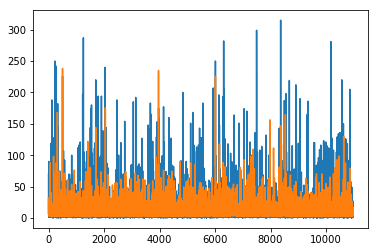

In [49]:
cm.plotActualPrediction_Test(cnn, True)  ## Get an overlay of the training set distribution versus the predicted distribution of the training set.

In [12]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [13]:
impute.getCategoriesWithNAN()  ## Get a list of columns in the original dataset that have NAN.

Index(['created', 'duration', 'fee_accepts', 'fee_amount', 'fee_currency',
       'fee_description', 'fee_label', 'fee_required', 'group_state',
       'how_to_find_us', 'pro_is_email_shared', 'rsvp_close_offset',
       'rsvp_limit', 'rsvp_open_offset', 'status', 'time', 'updated',
       'utc_offset', 'venue_address_1', 'venue_address_2', 'venue_city',
       'venue_country', 'venue_id', 'venue_lat',
       'venue_localized_country_name', 'venue_lon', 'venue_name',
       'venue_phone', 'venue_repinned', 'venue_state', 'venue_zip', 'why'],
      dtype='object')


In [14]:
impute.getCategoriesWithoutNAN()  ## Get a list of columns that don't have NAN in their values.

Index(['description', 'group_country', 'group_created', 'group_id',
       'group_join_mode', 'group_lat', 'group_localized_location', 'group_lon',
       'group_name', 'group_region', 'group_timezone', 'group_urlname',
       'group_who', 'id', 'link', 'local_date', 'local_time', 'name',
       'visibility', 'waitlist_count', 'yes_rsvp_count', 'month', 'day',
       'year', 'hour', 'day_of_week', 'weekend', 'month_meetup', 'day_meetup',
       'hour_meetup', 'day_of_week_meetup', 'weekend_meetup', 'geohash',
       'region', 'description_and_name'],
      dtype='object')


In [15]:
impute.getCategoricalCount('fee_required')  ## Get a frequency count of a given column; in this case fee_accepts.

              created  description  duration  fee_accepts  fee_amount  \
fee_required                                                            
False            4724         4724      4642         4724        4724   
True             2112         2112      2069         2112        2112   

              fee_currency  fee_description  fee_label  group_country  \
fee_required                                                            
False                 4724             1291       4724           4724   
True                  2112              504       2112           2112   

              group_created          ...           day_of_week  weekend  \
fee_required                         ...                                  
False                  4724          ...                  4724     4724   
True                   2112          ...                  2112     2112   

              month_meetup  day_meetup  hour_meetup  day_of_week_meetup  \
fee_required                          

In [16]:
new_df = impute.imputeGivenCategoricalVariable_RandomSampling('fee_required')  ## Let's try imputing the column with cash. We can do random sampling, where we print the distribution of the categorical variables below.  Thus, our random values will have a 0.69 chance of being False and a 0.31 chance of being True. 

False    0.691047
True     0.308953
Name: fee_required, dtype: float64


In [17]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(new_df, 'fee_required')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [60]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [61]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 500)               1378000   
_________________________________________________________________
dropout_60 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_61 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_62 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 501       
Total para

In [62]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

19.484006272061233


In [63]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the training set of the neural network model.  There doesn't see to be any improvement compared to the last model.

19.81071862612346


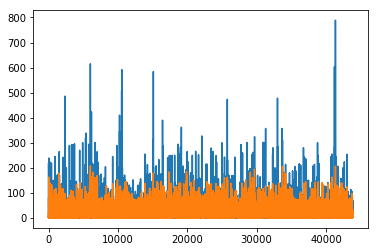

In [64]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

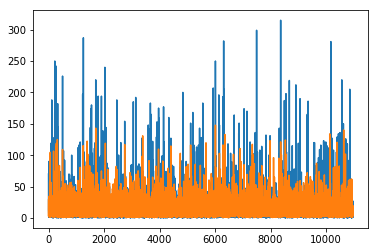

In [65]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the testing set.  There doesn't seem to be any improvement compared to the last model.

In [66]:
cnn = cm.convolutionalNeuralNetworkRegression()  ## Let's now try a convolutional neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 2752, 20)          100       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 1376, 20)          0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 1376, 20)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 1373, 20)          1620      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 686, 20)           0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 686, 20)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 683, 20)           1620      
__________

In [67]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

20.872241435993963


In [68]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.769757530135248


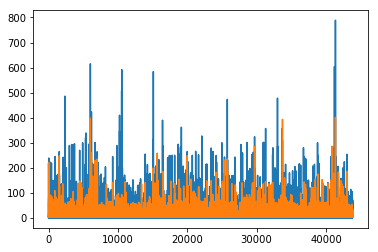

In [69]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

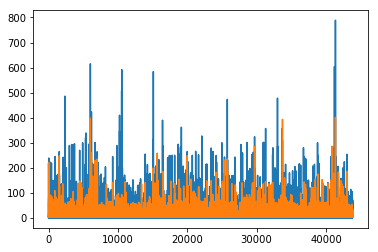

In [70]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

In [18]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [19]:
impute.getCategoricalCount('venue_repinned')  ## Get a frequency count of a given column; in this case venue_repinned.

                created  description  duration  fee_accepts  fee_amount  \
venue_repinned                                                            
False             18846        18846     17960         2463        2463   
True              21200        21200     21128         3767        3767   

                fee_currency  fee_description  fee_label  fee_required  \
venue_repinned                                                           
False                   2463              976       2463         18846   
True                    3767              492       3767         21200   

                group_country         ...          weekend  month_meetup  \
venue_repinned                        ...                                  
False                   18846         ...            18846         18846   
True                    21200         ...            21200         21200   

                day_meetup  hour_meetup  day_of_week_meetup  weekend_meetup  \
venue_repinned    

In [20]:
df = impute.imputeGivenCategoricalVariable_RandomSampling('venue_repinned')

True     0.529391
False    0.470609
Name: venue_repinned, dtype: float64


In [21]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(df, 'venue_repinned')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [75]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [76]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 500)               1379500   
_________________________________________________________________
dropout_103 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_104 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_105 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 501       
Total para

In [78]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

16.82977248827394


In [79]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the training set of the neural network model.

19.512160576211866


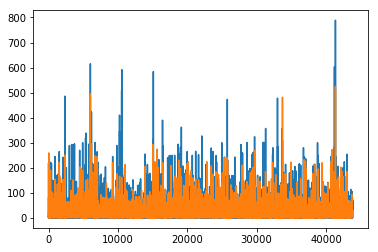

In [80]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

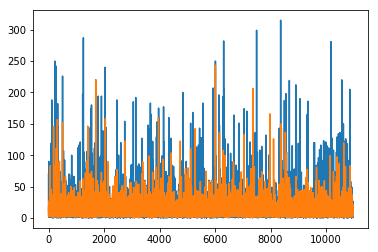

In [81]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the testing set.  

In [82]:
cnn = cm.convolutionalNeuralNetworkRegression()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 2755, 20)          100       
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 1377, 20)          0         
_________________________________________________________________
dropout_106 (Dropout)        (None, 1377, 20)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 1374, 20)          1620      
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 687, 20)           0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 687, 20)           0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 684, 20)           1620      
__________


Epoch 00018: val_mean_squared_error did not improve from 409.84297
Epoch 19/150
43880/43880 [==============================] - 80s 2ms/step - loss: 523.4430 - mean_squared_error: 523.4430 - val_loss: 407.0956 - val_mean_squared_error: 407.0956

Epoch 00019: val_mean_squared_error improved from 409.84297 to 407.09557, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 80s 2ms/step - loss: 501.6168 - mean_squared_error: 501.6168 - val_loss: 406.2147 - val_mean_squared_error: 406.2147

Epoch 00020: val_mean_squared_error improved from 407.09557 to 406.21470, saving model to nn_model_1.h5
Epoch 21/150
43880/43880 [==============================] - 81s 2ms/step - loss: 504.8649 - mean_squared_error: 504.8649 - val_loss: 398.7939 - val_mean_squared_error: 398.7939

Epoch 00021: val_mean_squared_error improved from 406.21470 to 398.79391, saving model to nn_model_1.h5
Epoch 22/150
43880/43880 [==============================] - 80s 2ms/step - loss: 491.3

In [83]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

20.403717191460736


In [84]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.690201319167965


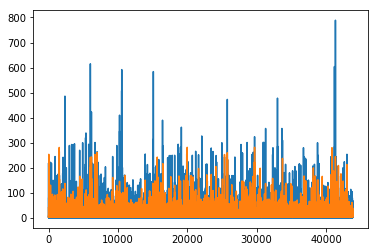

In [85]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

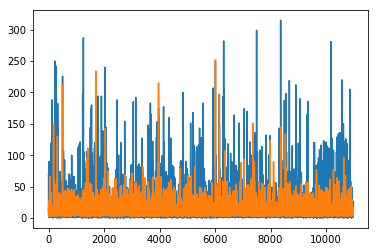

In [86]:
cm.plotActualPrediction_Test(cnn, True)  ## Get the plot overlay for the training set.  

In [22]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [23]:
impute.getCategoricalCount('pro_is_email_shared')  ## Get a frequency count of a given column; in this case pro_is_email_shared.

                     created  description  duration  fee_accepts  fee_amount  \
pro_is_email_shared                                                            
False                   2716         2716      2704          463         463   
True                      29           29        29            0           0   

                     fee_currency  fee_description  fee_label  fee_required  \
pro_is_email_shared                                                           
False                         463              116        463          2716   
True                            0                0          0            29   

                     group_country          ...           month_meetup  \
pro_is_email_shared                         ...                          
False                         2716          ...                   2716   
True                            29          ...                     29   

                     day_meetup  hour_meetup  day_of_week_meetup 

In [24]:
df = impute.imputeGivenCategoricalVariable('pro_is_email_shared', 'False') # In this case, we impute the common term here which is False instead of doing a random sample.

In [25]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(df, 'pro_is_email_shared')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [26]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [92]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 500)               1381500   
_________________________________________________________________
dropout_146 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_147 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_148 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 501       
Total para

43880/43880 [==============================] - 10s 224us/step - loss: 215.7733 - mean_squared_error: 215.7733 - val_loss: 458.8153 - val_mean_squared_error: 458.8153

Epoch 00028: val_mean_squared_error did not improve from 380.33194
Epoch 29/150
43880/43880 [==============================] - 10s 228us/step - loss: 229.2885 - mean_squared_error: 229.2885 - val_loss: 413.6887 - val_mean_squared_error: 413.6887

Epoch 00029: val_mean_squared_error did not improve from 380.33194
Epoch 30/150
43880/43880 [==============================] - 10s 230us/step - loss: 216.7392 - mean_squared_error: 216.7392 - val_loss: 416.3237 - val_mean_squared_error: 416.3237

Epoch 00030: val_mean_squared_error did not improve from 380.33194
Epoch 31/150
43880/43880 [==============================] - 10s 233us/step - loss: 200.3158 - mean_squared_error: 200.3158 - val_loss: 419.6927 - val_mean_squared_error: 419.6927

Epoch 00031: val_mean_squared_error did not improve from 380.33194
Epoch 32/150
43880/43880 

In [94]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

16.927448201548934


In [95]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the testing set of the neural network model.

19.502101533811796


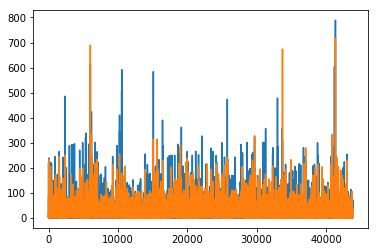

In [96]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

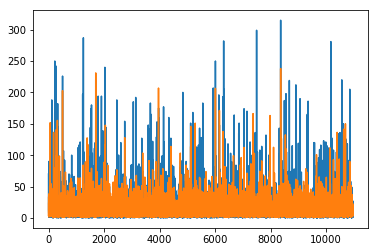

In [97]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the testing set.  Here, we see a slight improvement compared to the previous graphs.

In [98]:
cnn = cm.convolutionalNeuralNetworkRegression()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_86 (Conv1D)           (None, 2759, 20)          100       
_________________________________________________________________
max_pooling1d_86 (MaxPooling (None, 1379, 20)          0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 1379, 20)          0         
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 1376, 20)          1620      
_________________________________________________________________
max_pooling1d_87 (MaxPooling (None, 688, 20)           0         
_________________________________________________________________
dropout_150 (Dropout)        (None, 688, 20)           0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 685, 20)           1620      
__________


Epoch 00018: val_mean_squared_error did not improve from 408.31869
Epoch 19/150
43880/43880 [==============================] - 82s 2ms/step - loss: 502.5769 - mean_squared_error: 502.5769 - val_loss: 406.2721 - val_mean_squared_error: 406.2721

Epoch 00019: val_mean_squared_error improved from 408.31869 to 406.27210, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 81s 2ms/step - loss: 502.0086 - mean_squared_error: 502.0086 - val_loss: 403.1180 - val_mean_squared_error: 403.1180

Epoch 00020: val_mean_squared_error improved from 406.27210 to 403.11796, saving model to nn_model_1.h5
Epoch 21/150
43880/43880 [==============================] - 81s 2ms/step - loss: 502.6962 - mean_squared_error: 502.6962 - val_loss: 393.5692 - val_mean_squared_error: 393.5692

Epoch 00021: val_mean_squared_error improved from 403.11796 to 393.56924, saving model to nn_model_1.h5
Epoch 22/150
43880/43880 [==============================] - 82s 2ms/step - loss: 501.1

In [99]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

20.551859479964396


In [100]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.66802632218755


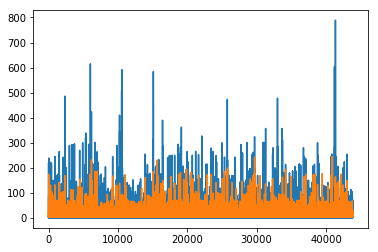

In [101]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

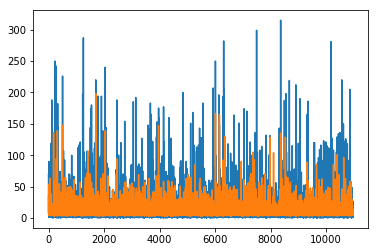

In [102]:
cm.plotActualPrediction_Test(cnn, True)  ## Get the plot overlay for the training set.  

In [27]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [28]:
impute.getCategoricalCount('duration')  ## Get a frequency count of a given column; in this case duration.  ## Get a frequency count of a given column; in this case fee_accepts.

              created  description  fee_accepts  fee_amount  fee_currency  \
duration                                                                    
6.000000e+04       94          180            0           0             0   
1.200000e+05        1           10            0           0             0   
2.400000e+05        0            1            0           0             0   
3.000000e+05        6            6            0           0             0   
6.000000e+05       25           26            1           1             1   
6.600000e+05        1            1            0           0             0   
7.200000e+05        0            1            0           0             0   
8.400000e+05        0           66            0           0             0   
9.000000e+05       89           95            0           0             0   
1.200000e+06        3            4            0           0             0   
1.800000e+06      223          317           28          28            28   

In [29]:
df = impute.imputeGivenCategoricalVariable_RandomSampling('duration')

7.200000e+06    0.296969
1.080000e+07    0.148927
3.600000e+06    0.083584
5.400000e+06    0.082982
9.000000e+06    0.069522
1.440000e+07    0.058810
1.800000e+07    0.026054
1.260000e+07    0.025169
2.160000e+07    0.017715
4.500000e+06    0.015267
2.520000e+07    0.013253
8.100000e+06    0.011276
1.620000e+07    0.011145
6.300000e+06    0.010241
2.880000e+07    0.009036
2.700000e+06    0.007869
1.800000e+06    0.005968
9.900000e+06    0.005949
1.980000e+07    0.004744
3.240000e+07    0.003671
2.700000e+07    0.003596
6.000000e+04    0.003389
1.170000e+07    0.003012
8.700000e+06    0.002918
2.340000e+07    0.002843
4.320000e+07    0.002692
3.600000e+07    0.002184
3.060000e+07    0.002127
1.530000e+07    0.001920
5.580000e+06    0.001807
                  ...   
1.026000e+07    0.000019
3.840000e+07    0.000019
3.192000e+07    0.000019
2.448000e+08    0.000019
3.600000e+08    0.000019
1.130400e+09    0.000019
8.514000e+08    0.000019
1.644000e+07    0.000019
1.326000e+07    0.000019


In [30]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(df, 'duration')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [108]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [109]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_105 (Dense)            (None, 500)               1382500   
_________________________________________________________________
dropout_189 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_190 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_191 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 501       
Total para

In [110]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

17.15920284356314


In [111]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the training set of the neural network model.

19.5178046546643


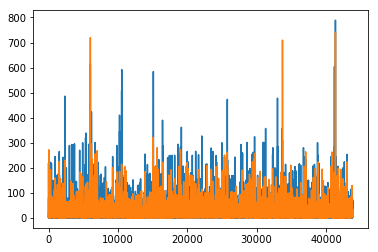

In [112]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

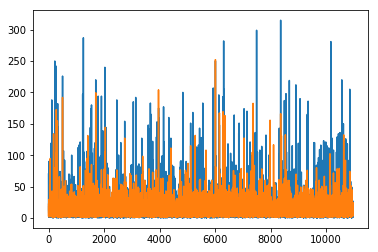

In [113]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the training set.  

In [114]:
cnn = cm.convolutionalNeuralNetworkRegression()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_111 (Conv1D)          (None, 2761, 20)          100       
_________________________________________________________________
max_pooling1d_111 (MaxPoolin (None, 1380, 20)          0         
_________________________________________________________________
dropout_192 (Dropout)        (None, 1380, 20)          0         
_________________________________________________________________
conv1d_112 (Conv1D)          (None, 1377, 20)          1620      
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 688, 20)           0         
_________________________________________________________________
dropout_193 (Dropout)        (None, 688, 20)           0         
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 685, 20)           1620      
__________

43880/43880 [==============================] - 81s 2ms/step - loss: 506.0248 - mean_squared_error: 506.0248 - val_loss: 402.8305 - val_mean_squared_error: 402.8305

Epoch 00019: val_mean_squared_error improved from 404.92048 to 402.83047, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 81s 2ms/step - loss: 504.9174 - mean_squared_error: 504.9174 - val_loss: 401.1766 - val_mean_squared_error: 401.1766

Epoch 00020: val_mean_squared_error improved from 402.83047 to 401.17658, saving model to nn_model_1.h5
Epoch 21/150
43880/43880 [==============================] - 81s 2ms/step - loss: 491.8383 - mean_squared_error: 491.8383 - val_loss: 392.1049 - val_mean_squared_error: 392.1049

Epoch 00021: val_mean_squared_error improved from 401.17658 to 392.10488, saving model to nn_model_1.h5
Epoch 22/150
43880/43880 [==============================] - 81s 2ms/step - loss: 489.9495 - mean_squared_error: 489.9495 - val_loss: 411.0298 - val_mean_squared_error:

In [115]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.028848504535148


In [116]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.60447478360419


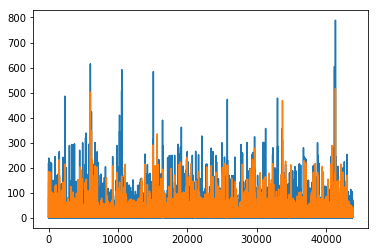

In [117]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

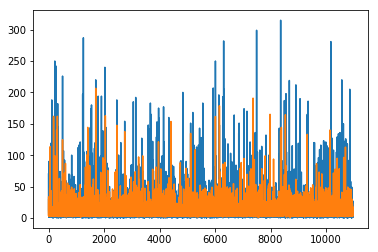

In [118]:
cm.plotActualPrediction_Test(cnn, True)  ## Get the plot overlay for the training set.  

In [31]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [32]:
impute.getCategoricalCount('rsvp_close_offset')  ## Get a frequency count of a given column; in this case rsvp_close_offset.

                   created  description  duration  fee_accepts  fee_amount  \
rsvp_close_offset                                                            
PT-144H                  1            1         1            0           0   
PT-167H                  1            1         1            0           0   
PT-321H-30M              1            1         1            0           0   
PT-42H-15M               1            1         1            0           0   
PT-46H-30M               1            1         1            0           0   
PT-47H                   1            1         1            0           0   
PT0S                    21           21        21            9           9   
PT101H30M                1            1         1            0           0   
PT104H50M                1            1         1            0           0   
PT10H                    2            2         2            1           1   
PT10H15M                10           10        10            1  

In [33]:
df = impute.imputeGivenCategoricalVariable_RandomSampling('rsvp_close_offset')

PT1H           0.119300
PT24H          0.081124
PT3H           0.054083
PT2H           0.050371
PT48H          0.033404
PT1H30M        0.027572
PT5H           0.022800
PT13H          0.021209
PT1M           0.018028
PT15M          0.018028
PT4H           0.016437
PT5H30M        0.013786
PT2H30M        0.012195
PT30M          0.012195
PT20H          0.011665
PT0S           0.011135
PT12H          0.010604
PT6H           0.010604
PT30H          0.010604
PT5H45M        0.010074
PT72H          0.010074
PT26H          0.010074
PT21H          0.009544
PT8H           0.009544
PT18H          0.009014
PT1H45M        0.009014
PT3H30M        0.009014
PT45M          0.009014
PT25H          0.008484
PT21H30M       0.008484
                 ...   
PT44H          0.000530
PT156H         0.000530
PT122H         0.000530
PT46H30M       0.000530
PT44H1M        0.000530
PT5H43M        0.000530
PT51H          0.000530
PT48H15M       0.000530
PT1296H        0.000530
PT33H30M       0.000530
PT74H45M       0

In [34]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(df, 'rsvp_close_offset')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [123]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [124]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 500)               1517500   
_________________________________________________________________
dropout_232 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_130 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_233 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_131 (Dense)            (None, 500)               250500    
_________________________________________________________________
dropout_234 (Dropout)        (None, 500)               0         
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 501       
Total para

In [125]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

12.851166114862622


In [126]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the training set of the neural network model.

19.714219109391646


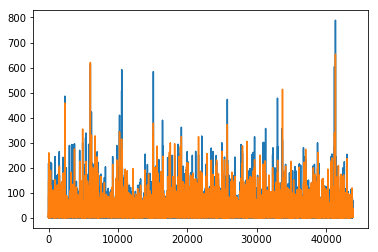

In [127]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

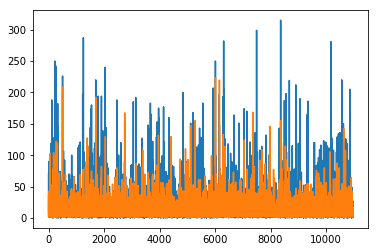

In [128]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the training set.  

In [129]:
cnn = cm.convolutionalNeuralNetworkRegression()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 3031, 20)          100       
_________________________________________________________________
max_pooling1d_136 (MaxPoolin (None, 1515, 20)          0         
_________________________________________________________________
dropout_235 (Dropout)        (None, 1515, 20)          0         
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 1512, 20)          1620      
_________________________________________________________________
max_pooling1d_137 (MaxPoolin (None, 756, 20)           0         
_________________________________________________________________
dropout_236 (Dropout)        (None, 756, 20)           0         
_________________________________________________________________
conv1d_138 (Conv1D)          (None, 753, 20)           1620      
__________


Epoch 00018: val_mean_squared_error improved from 389.81953 to 381.85071, saving model to nn_model_1.h5
Epoch 19/150
43880/43880 [==============================] - 91s 2ms/step - loss: 485.9544 - mean_squared_error: 485.9544 - val_loss: 381.7811 - val_mean_squared_error: 381.7811

Epoch 00019: val_mean_squared_error improved from 381.85071 to 381.78112, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 92s 2ms/step - loss: 476.0583 - mean_squared_error: 476.0583 - val_loss: 378.3780 - val_mean_squared_error: 378.3780

Epoch 00020: val_mean_squared_error improved from 381.78112 to 378.37801, saving model to nn_model_1.h5
Epoch 21/150
43880/43880 [==============================] - 92s 2ms/step - loss: 482.7075 - mean_squared_error: 482.7075 - val_loss: 379.7661 - val_mean_squared_error: 379.7661

Epoch 00021: val_mean_squared_error did not improve from 378.37801
Epoch 22/150
43880/43880 [==============================] - 91s 2ms/step - loss: 474.3

In [130]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.613168925688406


In [131]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.2414710339572


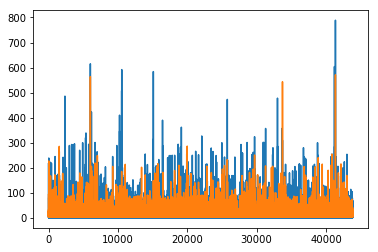

In [132]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

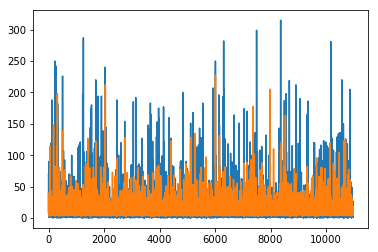

In [133]:
cm.plotActualPrediction_Test(cnn, True)  ## Get the plot overlay for the training set.  So far, this is the best density graph we have compared to the others.  It looks like the CNN is the best model for the variables we have so far.

In [35]:
impute = imputeVariables(mm)  ## Initialize the imputeVariables class with our dataset class.

In [36]:
impute.getCategoricalCount('rsvp_open_offset')  ## Get a frequency count of a given column; in this case rsvp_open_offset.

                  created  description  duration  fee_accepts  fee_amount  \
rsvp_open_offset                                                            
PT106H                  6            6         6            6           6   
PT109H16M               1            1         1            1           1   
PT110H30M               8            8         8            8           8   
PT1127H                 1            1         1            0           0   
PT112H                  1            1         1            1           1   
PT112H30M               8            8         8            8           8   
PT1149H                 1            1         1            0           0   
PT1152H                 1            1         1            0           0   
PT115H                  3            3         3            3           3   
PT118H                  1            1         1            1           1   
PT119H                  9            9         9            9           9   

In [37]:
df = impute.imputeGivenCategoricalVariable_RandomSampling('rsvp_open_offset')

PT185H15M    0.075370
PT168H       0.061911
PT24H        0.040377
PT144H       0.026918
PT133H       0.025572
PT138H       0.025572
PT27H        0.020188
PT163H       0.016151
PT127H       0.016151
PT154H       0.014805
PT179H45M    0.014805
PT649H       0.013459
PT529H       0.013459
PT343H30M    0.013459
PT62H15M     0.013459
PT336H       0.013459
PT153H       0.012113
PT165H       0.012113
PT119H       0.012113
PT71H        0.012113
PT80H30M     0.012113
PT2352H      0.012113
PT46H45M     0.012113
PT139H57M    0.012113
PT26H30M     0.012113
PT158H30M    0.012113
PT167H30M    0.012113
PT186H15M    0.010767
PT145H       0.010767
PT175H       0.010767
               ...   
PT732H       0.001346
PT331H       0.001346
PT863H       0.001346
PT743H       0.001346
PT334H10M    0.001346
PT118H       0.001346
PT210H30M    0.001346
PT936H15M    0.001346
PT346H30M    0.001346
PT504H30M    0.001346
PT509H30M    0.001346
PT733H       0.001346
PT158H       0.001346
PT265H30M    0.001346
PT528H    

In [38]:
## Rerun the functions to get the lemmatized_text for training and testing sets along with their corpuses.  We will be getting a modified
## dataset that has fee_accepts as a new column with the imputed value.  Our aim is to then try the best model we have so far (neural networks)
## and see if this variable lends some improvement to the model.
mm.joinToActualDataFrame(df, 'rsvp_open_offset')  ## Modify our dataset to include fee_accepts along with the imputed values that are there.
mm.createTrainTestSets()
mm.preprocessText("train")
mm.buildBigramTrigramModels()
data_lemmatized_train = mm.lemmatizeData()
mm.preprocessText("test")
mm.buildBigramTrigramModels()
data_lemmatized_test = mm.lemmatizeData()
ldaClass = LdaModel(data_lemmatized_train)
ldaClass.loadModel("model.m")
corpus = ldaClass.returnCorpus()
ldaClass_test = LdaModel(data_lemmatized_test)
corpus_test = ldaClass_test.returnCorpus()
lda_model = ldaClass.returnModel()

['Futsal games (intermediate advanced level) dollars player game; through '
 'paypal. Welcome thank being futsal Across America; please aware payment '
 '9-10PM, game. Please follow reinforce Refunds: Cancel hours before refund. '
 'refund cancelations; exceptions. school William O’Shea (100W): Terms '
 'Conditions participating group: PLEASE THESE TERMS CONDITIONS CAREFULLY. '
 'USING WEBSITE, AGREE THESE TERMS CONDITIONS. JOINING SIGNING FUTSAL ACROSS '
 'AMERICA ACTIVITIES AGREEMENT: certify years older known medical other '
 'conditions could interfere participation FUTSAL ACROSS AMERICA activities. '
 'understand accept practice soccer/futsal, indoor outdoor, involves certain '
 'risks physical injury. Therefore individually, hereby release discharge, '
 'FUTSAL ACROSS AMERICA Organizers Co-organizers claims, actions, damages, '
 'losses, liabilities, costs expenses whatsoever, including limited claims '
 'negligence, arising resulting from, reason connection participation FUTSAL 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['futsal', 'games', 'intermediate', 'advanced', 'level_dollars_player', 'through', 'paypal', 'welcome', 'thank', 'being', 'futsal_across_america', 'please', 'aware', 'payment', 'please', 'follow_reinforce_refunds', 'cancel', 'hours', 'before', 'refund_refund_cancelations', 'exceptions', 'school_william', 'terms_conditions_participating', 'group', 'please', 'these', 'terms_conditions_carefully', 'using', 'website', 'agree', 'these', 'terms_conditions_joining_signing', 'futsal_across_america', 'activities_agreement_certify_years', 'older_known_medical', 'other', 'conditions_could_interfere', 'participation_futsal_across_america', 'activities', 'understand_accept', 'practice', 'soccer', 'futsal_indoor_outdoor', 'involves_certain_risks_physical', 'injury_therefore_individually_hereby', 'release_discharge_futsal_across', 'america', 'organizers_organizers_claims', 'actions_damages_losses_liabilities', 'costs_expenses_whatsoever_including', 'limited_claims_negligence', 'arising_resulting_reas

In [39]:
cm = createModels(lda_model, corpus, corpus_test, mm)  ## With our LDA model, training corpus, testing corpus, and dataset class, we can initialize our class for creating the models. 

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [40]:
nn = cm.neuralNetworkRegression()  ## Let's try training a neural network regression.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               1615000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total para

In [41]:
cm.getRMSE_Train(nn, False)  ## Get the RMS for the training set of the neural network model.

19.96113128643595


In [42]:
cm.getRMSE_Test(nn, False)  ## Get the RMS for the training set of the neural network model.

19.62971432769504


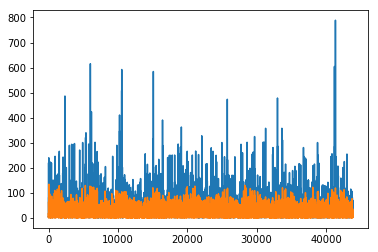

In [43]:
cm.plotActualPrediction_Train(nn, False)  ## Get the plot overlay for the training set.  

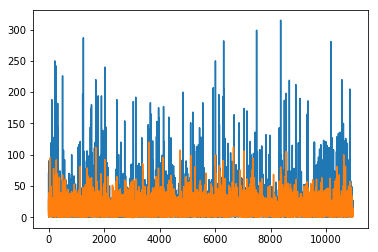

In [44]:
cm.plotActualPrediction_Test(nn, False)  ## Get the plot overlay for the training set.  

In [45]:
cnn = cm.convolutionalNeuralNetworkRegression()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3226, 20)          100       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1613, 20)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1613, 20)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1610, 20)          1620      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 805, 20)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 805, 20)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 802, 20)           1620      
__________


Epoch 00018: val_mean_squared_error did not improve from 406.54502
Epoch 19/150
43880/43880 [==============================] - 102s 2ms/step - loss: 492.6901 - mean_squared_error: 492.6901 - val_loss: 400.3443 - val_mean_squared_error: 400.3443

Epoch 00019: val_mean_squared_error improved from 406.54502 to 400.34429, saving model to nn_model_1.h5
Epoch 20/150
43880/43880 [==============================] - 102s 2ms/step - loss: 481.9050 - mean_squared_error: 481.9050 - val_loss: 397.9213 - val_mean_squared_error: 397.9213

Epoch 00020: val_mean_squared_error improved from 400.34429 to 397.92135, saving model to nn_model_1.h5
Epoch 21/150
43880/43880 [==============================] - 103s 2ms/step - loss: 473.5376 - mean_squared_error: 473.5376 - val_loss: 401.9236 - val_mean_squared_error: 401.9236

Epoch 00021: val_mean_squared_error did not improve from 397.92135
Epoch 22/150
43880/43880 [==============================] - 103s 2ms/step - loss: 461.3830 - mean_squared_error: 461.383

In [46]:
cm.getRMSE_Train(cnn, True)  ## Get the RMS for the training set of the neural network model.

18.922911171983817


In [47]:
cm.getRMSE_Test(cnn, True)  ## Get the RMS for the training set of the neural network model.

19.53107572920632


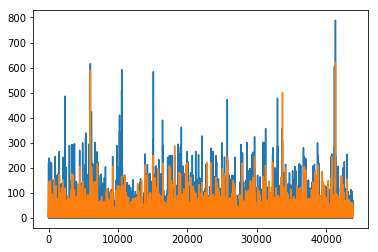

In [48]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

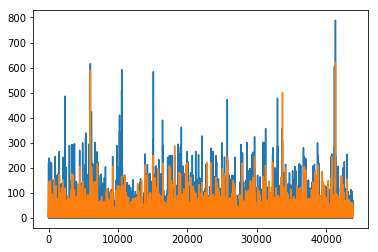

In [49]:
cm.plotActualPrediction_Train(cnn, True)  ## Get the plot overlay for the training set.  

1)	The basic idea and intuition was to approach this as a regression problem.  The idea is that I would first prepare my dataset by cleaning the dataset, imputing data, etc.  For text data in the description and name of the group, I would gather numerical data, mainly in the form of topic modeling and sentiment analysis.  Once the topic and sentiment data were incorporated, I would try various regression models and see which model has the best mean squared error on validation data.  

Also, I would plot the prediction data against the validation data and see if the distributions line up.  I then would incrementally add imputed data and see how close the distributions approximate.  The goal is to see if the model lines up with the real world validation data along with getting insights on what it predicts well and what it doesn’t predict well.

2)  The steps I took for my problem were the following:  First, I imported the dataset and looked at which columns had missing data and which didn’t.  I would start off with a baseline of using columns of data where the data was already available.  Included in this baseline would be the dates of the meet up, as only 58 values were missing out of the total dataset, so minor imputation would make little difference.  From the dates, I would get the month, day and time of the data.  I also would get the day of the week along with creating a variable for indicating if it’s the weekend or not.  The idea is that the density of people going to a meet up will be different on a weekend compared to a workday.  

Next, for whichever variables in my dataset were categorical variables, I would transform them to one-hot encoding.  Next, I would split randomly my dataset into 80% for training and 20% for testing.  This would amount to approximately 48000 samples for training and 10000 samples for testing.  Next, I would preprocess the text data in the name of the event and description of the group by removing stop words, removing emails, special characters, setting to lower case, tokenizing, identifying bigrams and trigrams, and finally lemmatizing the tokens.

After getting the training and testing sets lemmatized, I next would get the topic models using LDA from the gensim library on the training set.  For this, I aim to get 30 topics along with their keywords for each topic.  Once the topics are calculated, I will then get the topic distributions for the training and testing sets using this model.  The idea for using topic modeling that we can get a flavor of what the groups are as groups with similar topics are likely to attract the same number of people proportional to the size of the meeting place.  Once that is incorporated into both sets, I then perform a sentiment analysis on my dataset.  The idea is that description’s of the group with a near 0 sentiment will indicate a very formal group, while a positive sentiment will indicate an informal group.  Each will likely to have different amounts of people going to them.

Once both have been incorporated, I’m then ready to train my models.  I will prototype a random forest regression, gradient boosting regression, and a neural network regression.  I will use a linear regression as a baseline for my model.  By examining the mean squared error on the testing set of the models, along with a plot of their distributions, I can make a determination of which model I can proceed with.

Finally, once I have found a model with a good starting mean squared error and distribution, I then will gradually impute variables from columns that had NaN on them.  I will look at the distribution of the dataset and determine whether I should impute the median or randomly sample from the column and use that to fill in the NaN’s.  I will then retrain the dataset and see if that made a difference to the distribution.

3)  Visualizations are present in the python notebook.  They include a graph of the topic modelings, indicating the words used to denote a given topic by highlighting each topic number.  From these words, one can infer which topic they would refer to.  Another visualization will the plotting of the predicted distribution for each model versus the actual distribution.  The aim is to see which model creates a good approximation of the actual distribution.  It could be the case the the mean squared error is less for another model, but predicts roughly the same structure for a given model.  In that case, we would use that model and build on it with additional data.

4)  I was able to complete the code in the allotted time.  I think that I was able to get all the features I wanted into the program.

5)  If I was allotted 4-8 weeks to do the project, I would do the following research into seeing if it would improve the model.

-- I would see if I can incorporate additional vectors based on the text in the group name and description.  I would try things as basic as TF-IDF to something more state of the art as sent2vec.  I would see if incorporating these numerical vectors would make a difference on approximating the predicted model more to the testing model as well as reducing RMS.

-- Since we have the cities of the meetups, I would have tried something via geocoder from python what the population and city areas were for those cities.  Having more context on the population could give a better effect the proportion of people willing to go to a meetup.

-- Since the convolutional neural network was found to be the best regression model, I would try all sorts of different architectures in deep learning, whether it would be a deeper neural network, different convolutional neural network architectures or recursive neural network.  I would also try things like Gaussian Noise as a way to regularize the architecture and see if it improves the testing RMS.

-- I would have imputed more variables that had NAN and checked whether for each variable the median or random sampling worked better.  From the overlay of the distributions, I would get better insight into seeing which values approximated the distribution better and getting insight from that.

-- One angle of research shows that meetups can be differentiated between the use of formal and informal words.  So I would create a list of formal words and that of informal ones.  I would have a one hot encoding that would keep track of each.  I could then train on the one-hot
encoding of what formal or informal words were present.

-- Finally, I would try calibrating the geohashing.  The geohashing can be configured based on a given level.  Our level had 13 categories.  The next level would have 41 categories.  So I would see which level would yield the optimum results